## Modelling & Evaluation

In [55]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from collections import Counter







In [56]:
# load cleaned dataset
df=pd.read_csv("cleaned_data.csv")


#Selecting target and features from the dataframe
target_cols = ['coupon', 'expiration']
X = df.drop(columns=target_cols)
y = df[target_cols]

In [57]:
#automatically separate columns by dtype
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()

print("Categorical:", categorical_cols)
print("Numerical:", numerical_cols)




Categorical: ['destination', 'passenger', 'weather', 'time', 'gender', 'age', 'maritalStatus', 'education', 'occupation', 'income', 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50', 'age_group']
Numerical: ['temperature', 'has_children', 'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same', 'direction_opp', 'Y']


In [58]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y['coupon']  
)


### Processing
A preprocessing pipeline was created, where numeric columns underwent median imputation and standardization (StandardScaler), while categorical columns were processed using imputation and one-hot encoding

In [59]:
# Preprocessing for numerical and categorical features
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)


In [60]:
# Building pipeline
logreg = LogisticRegression(max_iter=1000)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', MultiOutputClassifier(logreg))
])

# Train model
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['temperature',
                                                   'has_children',
                                                   'toCoupon_GEQ5min',
                                                   'toCoupon_GEQ15min',
                                                   'toCoupon_GEQ25min',
                                                   'direction_same',
                                                   'direction_opp', 'Y']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['destination', 'passenger',
                                                   'weather', 'time', 'gender',
                                                   'age', 'maritalStatus',
                                                   'education', 'occupation',
                                                   'income', 'Bar',
                                                   'CoffeeHouse', 'CarryAway',
                                                   'RestaurantLessThan20',
                                                   'Restaurant20To50',
                                                   'age_group'])])),
                ('clf',
                 MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000)))])

In [61]:
#Model evaluation
y_pred = pipeline.predict(X_test)

print("\nClassification Report for Coupon:\n")
print(classification_report(y_test['coupon'], y_pred[:,0]))

print("\nClassification Report for Expiration:\n")
print(classification_report(y_test['expiration'], y_pred[:,1]))



Classification Report for Coupon:

                       precision    recall  f1-score   support

                  Bar       0.42      0.37      0.40       402
Carry out & Take away       0.44      0.41      0.42       469
         Coffee House       0.42      0.59      0.49       798
    Restaurant(20-50)       0.55      0.25      0.35       297
      Restaurant(<20)       0.41      0.36      0.39       556

             accuracy                           0.43      2522
            macro avg       0.45      0.40      0.41      2522
         weighted avg       0.44      0.43      0.42      2522


Classification Report for Expiration:

              precision    recall  f1-score   support

          1d       0.63      0.71      0.67      1392
          2h       0.57      0.48      0.52      1130

    accuracy                           0.61      2522
   macro avg       0.60      0.59      0.59      2522
weighted avg       0.60      0.61      0.60      2522



Observation and recommendation
**Coupon**
* Overall accuracy is 43%, which is only slightly better than random guessing for a 5-class problem.
* The Coffee House class has the highest recall (0.58) — the model is relatively better at identifying this class, though precision remains low.
* The Restaurant(20-50) class has particularly low recall (0.25), meaning the model misses most of these instances.
* The F1-scores for all classes are below 0.50, indicating poor balance between precision & recall.
* Weighted average F1-score: 0.42

**Expiration**
* Overall accuracy is 61%, better than the coupon task.
* The model performs better on the 1d class, with higher recall and F1.
* The 2h class has lower precision & recall, meaning the model struggles to identify it correctly.
* Weighted F1-score: 0.60

**Recommendations**
* Address potential class imbalance in the targets.
* Perform feature engineering, such as grouping rare categories
* Experiment with advanced models (e.g., Random Forest, Gradient Boosting) and tune hyperparameters.
* Use cross-validation for more robust evaluation and avoid overfitting.



In [62]:

# Define the models 
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': None,  
    'LightGBM': None
}

target_cols = ['coupon', 'expiration']

for target in target_cols:
    print(f"\nTarget: {target} ")
    n_classes = len(np.unique(y_train[target]))
    print(f"Detected {n_classes} classes for target: {target}")
    
    # re-define models with correct params for multi-class
    models['XGBoost'] = XGBClassifier(
        objective='multi:softmax',
        num_class=n_classes,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    )
    models['LightGBM'] = LGBMClassifier(
        objective='multiclass',
        num_class=n_classes,
        random_state=42
    )

    for name, model in models.items():
        print(f"\nModel: {name}")

        # Create pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),   
            ('classifier', model)
        ])

        # Train
        pipeline.fit(X_train, y_train[target])

        # Predict
        y_pred = pipeline.predict(X_test)

        # Evaluate
        acc = accuracy_score(y_test[target], y_pred)
        print(f"Accuracy: {acc:.3f}")
        print("Confusion Matrix:")
        print(confusion_matrix(y_test[target], y_pred))
        print("Classification Report:")
        print(classification_report(y_test[target], y_pred))



Target: coupon 
Detected 5 classes for target: coupon

Model: Random Forest
Accuracy: 0.726
Confusion Matrix:
[[284   6  74   9  29]
 [  5 346  74   9  35]
 [ 59  40 624  14  61]
 [ 10   4  52 182  49]
 [ 26  42  79  15 394]]
Classification Report:
                       precision    recall  f1-score   support

                  Bar       0.74      0.71      0.72       402
Carry out & Take away       0.79      0.74      0.76       469
         Coffee House       0.69      0.78      0.73       798
    Restaurant(20-50)       0.79      0.61      0.69       297
      Restaurant(<20)       0.69      0.71      0.70       556

             accuracy                           0.73      2522
            macro avg       0.74      0.71      0.72      2522
         weighted avg       0.73      0.73      0.73      2522


Model: XGBoost
[14:48:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This m

#### General Observation 
All advanced models outperform Logistic Regression, which had 69% accuracy and lower recall/F1-scores.

All three models (Random Forest, XGBoost, LightGBM) perform well and consistently, with LightGBM slightly outperforming the others.
Best accuracy: 77% (LightGBM)

Class imbalance still affects class 0 — all models have lower recall on class 0, meaning many 0s are wrongly predicted as 1s.

Class 1 (majority) is predicted well across all models (recall 82%).37
weighted avg       0.74      0.74      0.74      2537


**Recommendations**
Proceed to LightGB as the preferred model for deployment or further tuning.

Investigate classes with lower recall (like Restaurant(20-50) and Bar) — possibly due to underrepresentation or overlapping features.

If desired, explore hyperparameter tuning or feature engineering to improve the weaker classes.

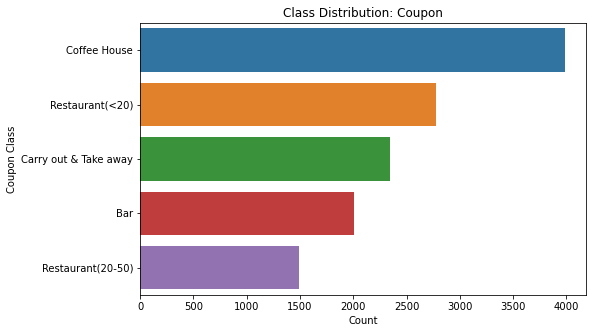

In [63]:
# check distribution of coupon classes
plt.figure(figsize=(8, 5))
sns.countplot(y=df['coupon'], order=df['coupon'].value_counts().index)
plt.title("Class Distribution: Coupon")
plt.xlabel("Count")
plt.ylabel("Coupon Class")
plt.show()

 We'll use SMOTE (Synthetic Minority Oversampling Technique) to handle the rare classes (e.g., Restaurant(20-50) and Bar) in your coupon target

In [ ]:
# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np

# assume df is your cleaned DataFrame
X = df.drop(columns=['coupon', 'expiration'])
y = df[['coupon', 'expiration']]   # both targets

# Work on coupon first
target = 'coupon'

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y[target], test_size=0.2, random_state=42, stratify=y[target]
)

print("Original class distribution:\n", y_train.value_counts())

# Encode categorical features
categorical_cols = X_train.select_dtypes(include='object').columns
numerical_cols = X_train.select_dtypes(exclude='object').columns

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', 'passthrough', numerical_cols)
])

X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

print(f"Encoded X_train shape: {X_train_encoded.shape}")

# Apply SMOTE on encoded data
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_encoded, y_train)

print("\nAfter SMOTE class distribution:\n", pd.Series(y_train_sm).value_counts())

# Train LightGBM on SMOTE data
model = LGBMClassifier(random_state=42)

model.fit(X_train_sm, y_train_sm)

# Predict on test set
y_pred = model.predict(X_test_encoded)

# Evaluation
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.3f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Original class distribution:
 Coffee House             3191
Restaurant(<20)          2223
Carry out & Take away    1875
Bar                      1608
Restaurant(20-50)        1191
Name: coupon, dtype: int64
Encoded X_train shape: (10088, 111)

After SMOTE class distribution:
 Restaurant(<20)          3191
Bar                      3191
Coffee House             3191
Restaurant(20-50)        3191
Carry out & Take away    3191
Name: coupon, dtype: int64
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22016
[LightGBM] [Info] Number of data points in the train set: 15955, number of used features: 110
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start train

### Hyper-parameter tuning

In [69]:

from sklearn.model_selection import GridSearchCV

param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200]
}

grid = GridSearchCV(LGBMClassifier(random_state=42), param_grid, cv=3)
grid.fit(X_train_sm, y_train_sm)

print("Best params:", grid.best_params_)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21867
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 110
[LightGBM] [Info] Start training from score -1.609532
[LightGBM] [Info] Start training from score -1.609532
[LightGBM] [Info] Start training from score -1.609062
[LightGBM] [Info] Start training from score -1.609532
[LightGBM] [Info] Start training from score -1.609532
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19367
[LightGBM] [Info] Number of data points in the train set: 10637, number of used features: 110
[LightGBM] [Info] St